In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#Se importa la Base de datos a un data frame
file_path = '/content/drive/MyDrive/Inv. teórica/Base de Datos/soc-redditHyperlinks-title.tsv'
df = pd.read_csv(file_path, delimiter='\t')

In [ ]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Iterar a través del DataFrame para añadir nodos y enlaces
for index, row in df.iterrows():
    source = row['SOURCE_SUBREDDIT']
    target = row['TARGET_SUBREDDIT']
    post_label = row['LINK_SENTIMENT']
    post_properties = list(map(float, row['PROPERTIES'].split(',')))

    # Añadir nodos
    if not G.has_node(source):
        G.add_node(source)
    if not G.has_node(target):
        G.add_node(target)

    # Añadir un enlace dirigido del subreddit fuente al subreddit objetivo
    G.add_edge(source, target, post_label=post_label, post_properties=post_properties)

In [ ]:
len(G)

54075

# Exploración de la red general

Distribución de Grado de entrada y salida

In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo
in_degrees = dict(G.in_degree())  # Grado de entrada
out_degrees = dict(G.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

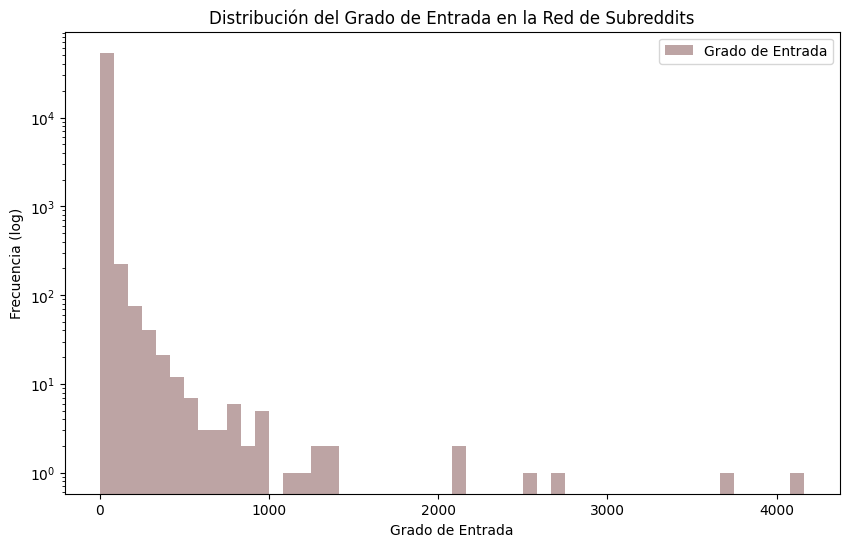

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Red de Subreddits')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

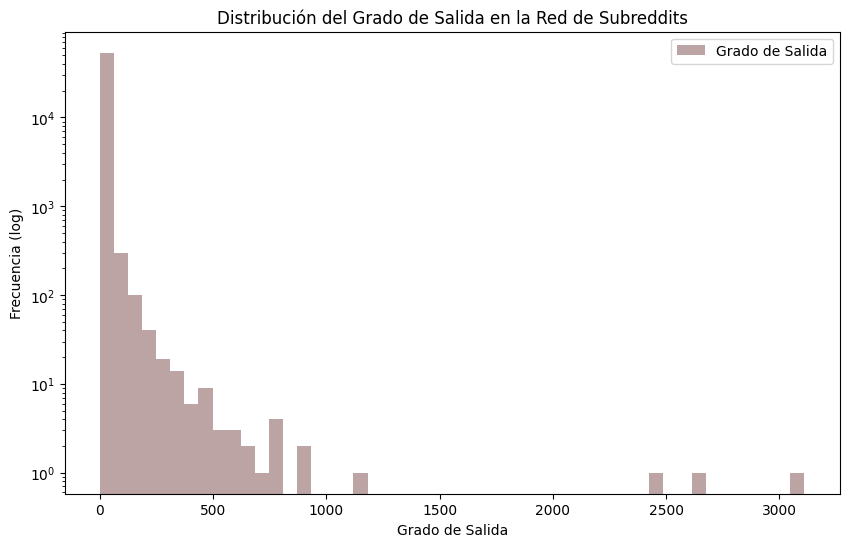

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Red de Subreddits')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

La distribución tiene una forma de cola larga (long-tail), lo cual es típico de muchas redes sociales y naturales. Esto significa que la mayoría de los subreddits tienen un grado de salida relativamente bajo (hacen referencia a unos pocos otros subreddits), mientras que hay unos pocos subreddits con un grado de salida muy alto (hacen referencia a muchos otros subreddits).

Los nodos con un alto grado de salida pueden ser considerados como influenciadores o puntos de difusión clave, ya que enlazan a muchos otros subreddits. Estos subreddits podrían jugar un papel importante en la propagación de información e ideologías.

La naturaleza de la cola larga sugiere que la distribución podría ajustarse a una ley de potencia, lo que es común en las redes de escala libre. Esto implica que hay mecanismos de crecimiento de red como el "attachment preferencial", donde los nuevos enlaces tienen una mayor probabilidad de conectarse a nodos ya bien conectados.

Los subreddits con grados de salida medios a altos podrían ser lugares estratégicos para el monitoreo o la intervención de la difusión de información, especialmente si están relacionados con la política o ideologías específicas.

Las redes con esta distribución de grado son generalmente robustas a la eliminación aleatoria de nodos pero pueden ser vulnerables a ataques dirigidos (es decir, la eliminación de los nodos más conectados).



In [ ]:
density = nx.density(G)
print(f'Densidad de la red: {density}')

Densidad de la red: 8.029680598483293e-05


In [ ]:
# Convertir a grafo no dirigido
G_undirected = G.to_undirected()

# Encontrar todas las componentes conexas
connected_components = list(nx.connected_components(G_undirected))

# Contar el número de componentes conexas
num_connected_components = len(connected_components)
print(f'Número de componentes conexas: {num_connected_components}')

Número de componentes conexas: 758


hay 758 grupos aislados de subreddits en los que cada grupo está interconectado internamente, pero no hay enlaces entre los grupos.

In [ ]:
# Encontrar la componente gigante
largest_component = max(connected_components, key=len)

# Crear un subgrafo que contiene solo los nodos de la componente gigante
subgraph_giant_component = G_undirected.subgraph(largest_component)

# Analizar la componente gigante
num_nodes_giant = subgraph_giant_component.number_of_nodes()
num_edges_giant = subgraph_giant_component.number_of_edges()
density_giant = nx.density(subgraph_giant_component)

print(f'Número de nodos en la componente gigante: {num_nodes_giant}')
#print(f'Número de enlaces en la componente gigante: {num_edges_giant}')
print(f'Densidad de la componente gigante: {density_giant}')

Número de nodos en la componente gigante: 52468
Densidad de la componente gigante: 0.00015932354588831906


La gran mayoría de los subreddits (52,468 de 54,075) están en la componente gigante. Esto implica que casi todos los subreddits están de alguna manera interconectados, aunque sea indirectamente, y podrían influenciarse entre sí a través de una cadena de enlaces.




Esto nos dice que la difusión de información probablemente depende de rutas específicas a través de ciertos nodos clave o influyentes, en lugar de una difusión uniforme a través de la red. Y esto es lo que queremos explorar en nuestro proyecto.

------------------------------

In [ ]:

# Obtener las componentes fuertemente conectadas (SCC) de G
strongly_connected_components = list(nx.strongly_connected_components(G))

# Encontrar la componente gigante (la de mayor tamaño)
giant_component = max(strongly_connected_components, key=len)

# Crear un subgrafo a partir de la componente gigante
G1 = G.subgraph(giant_component).copy()

# Verifica si el subgrafo G1 es dirigido
print(nx.is_directed(G1))  # Esto debería devolver True

True


In [ ]:
len(giant_component)

14389

In [ ]:
num_components = nx.number_weakly_connected_components(G)
print(f"Número de componentes débilmente conectadas: {num_components}")


Número de componentes débilmente conectadas: 758


In [ ]:
weakly_connected_components = list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weakly_connected_components]
component_sizes.sort(reverse=True)  # Ordenar de mayor a menor

print(f"Las 5 componentes más grandes tienen estos tamaños: {component_sizes[:5]}")


Las 5 componentes más grandes tienen estos tamaños: [52468, 8, 7, 6, 6]


In [ ]:
# Encontrar la componente gigante débilmente conectada (Weakly Connected Component)
largest_weakly_connected_component = max(nx.weakly_connected_components(G), key=len)

# Verificar el número de nodos en esta componente antes de crear el subgrafo
print(f"Número de nodos en largest_weakly_connected_component: {len(largest_weakly_connected_component)}")


Número de nodos en largest_weakly_connected_component: 52468


In [ ]:
# Crear un subgrafo a partir de la componente gigante débilmente conectada
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verificar que el subgrafo G1 tiene los mismos nodos
print(f"Número de nodos en G1: {G1.number_of_nodes()}")


Número de nodos en G1: 52468


In [ ]:
# Crear una copia de G1 con los atributos de tipo lista convertidos a cadenas
G1_copy = G1.copy()

for u, v, data in G1_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo G1_copy en un archivo GraphML
nx.write_graphml(G1_copy,  "/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_giant.gexf")



In [ ]:
# Asegúrate de que G1 es una copia real
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verifica si el subgrafo G1 es dirigido
print(f"G1 es dirigido: {nx.is_directed(G1)}")


G1 es dirigido: True


In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo
in_degrees_giant = dict(G1.in_degree())  # Grado de entrada
out_degrees_giant = dict(G1.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

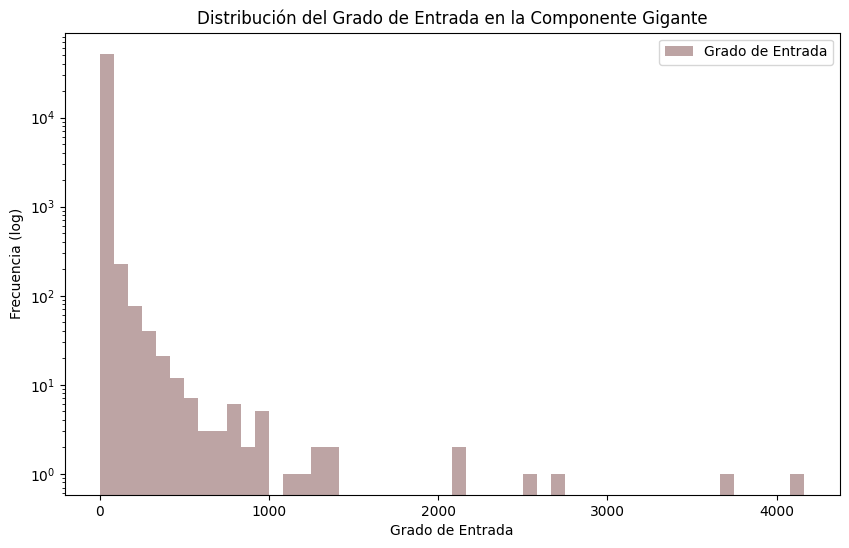

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Componente Gigante')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

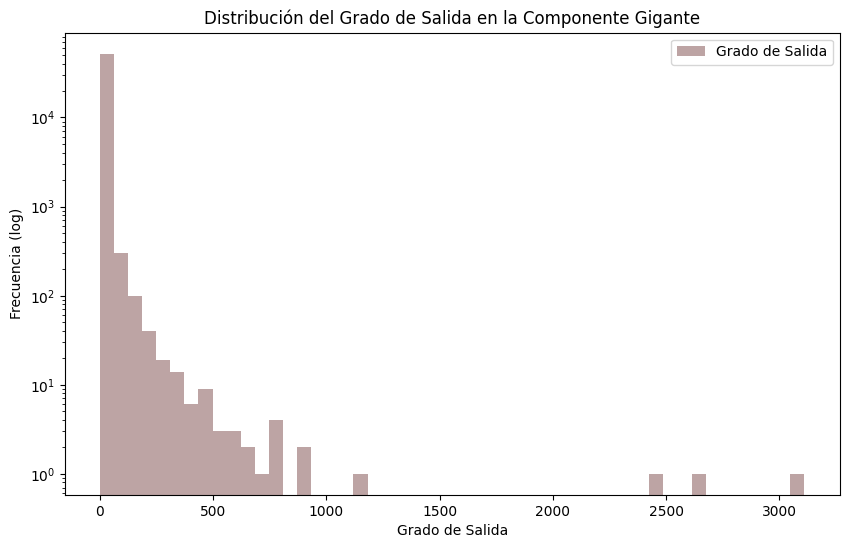

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Componente Gigante')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

**Medidas de centralidad**

Centralidad de Grado

In [ ]:
# Calcular centralidad de grado
degree_centrality = nx.degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
# Obtener los 50 nodos más influyentes según la centralidad de grado
top_50_nodes_by_degree = sorted_degree_centrality[:50]

# Mostrar los 50 nodos más influyentes con su centralidad de grado
for node, centrality in top_50_nodes_by_degree:
    print(f"Nodo: {node}, Centralidad de Grado: {centrality}")

In [ ]:
# Calcular centralidad de grado de entrada
in_degree_centrality = nx.in_degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar por centralidad de grado de entrada
sorted_degree_centrality_in = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Calcular centralidad de grado de salida
out_degree_centrality = nx.out_degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar por centralidad de grado de salida
sorted_degree_centrality_out = sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)

Centralidad de Intermediación

In [ ]:
# Calcular la centralidad de intermediación (betweenness centrality) para todos los nodos
# Versión exacta - consume mucho tiempo de ejecución
betweenness_dict = nx.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)

# Ordenar los nodos por su centralidad de intermediación
sorted_betweenness = sorted(betweenness_dict.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes
top_50_nodes_by_betweenness = sorted_betweenness[:50]

for node, centrality in top_50_nodes_by_betweenness:
    print(f"Nodo: {node}, Centralidad de Intermediación: {centrality}")

NameError: name 'nx' is not defined

In [ ]:
# Asumiendo que G es tu grafo dirigido
# k es el número de nodos de origen a utilizar en el cálculo
k = 1000

# Calcular la centralidad de intermediación aproximada
betweenness_centrality_approx = nx.betweenness_centrality(G1, k=k, normalized=True, endpoints=False)

# Ordenar los nodos por su centralidad de intermediación aproximada
sorted_betweenness_approx = sorted(betweenness_centrality_approx.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes según la centralidad de intermediación aproximada
top_50_nodes_by_betweenness_approx = sorted_betweenness_approx[:50]

# Imprimir los 50 nodos más influyentes con su centralidad de intermediación aproximada
for node, centrality in top_50_nodes_by_betweenness_approx:
    print(f"Nodo: {node}, Centralidad de Intermediación Aproximada: {centrality}")

Centralidad de Vector Propio

In [ ]:
# Calcular la centralidad de vector propio (eigenvector centrality)
eigenvector_dict = nx.eigenvector_centrality_numpy(G)

# Ordenar los nodos por su centralidad de vector propio
sorted_eigenvector = sorted(eigenvector_dict.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes
top_50_nodes_by_eigenvector = sorted_eigenvector[:50]

for node, centrality in top_50_nodes_by_eigenvector:
    print(f"Nodo: {node}, Centralidad de Vector Propio: {centrality}")

Centralidad de Cercanía

In [ ]:
# Calcular la centralidad de cercanía para todos los nodos
# Versión exacta - consume mucho tiempo de ejecución
closeness_dict = nx.closeness_centrality(G)

# Ordenar los nodos por su centralidad de cercanía
sorted_closeness = sorted(closeness_dict.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes
top_50_nodes_by_closeness = sorted_closeness[:50]

for node, centrality in top_50_nodes_by_closeness:
    print(f"Nodo: {node}, Centralidad de Cercanía: {centrality}")

Pasamos de listas de tuplas a diccionarios para cada medida

In [ ]:
degree_centrality_in_dict = dict(sorted_degree_centrality_in)
degree_centrality_out_dict = dict(sorted_degree_centrality_out)
eigenvector_centrality_dict = dict(sorted_eigenvector)  # Asegúrate de tener esta lista de tuplas ordenada para eigenvector
#closeness_centrality_dict = dict(sorted_closeness)
betweenness_centrality_dict = dict(sorted_betweenness_approx)

In [ ]:
# Convertir los diccionarios en un DataFrame de pandas para facilitar el análisis
centrality_df = pd.DataFrame({
    'degree_in': pd.Series(degree_centrality_in_dict),
    'degree_out': pd.Series(degree_centrality_out_dict),
    'eigenvector': pd.Series(eigenvector_centrality_dict),
    #'closeness': pd.Series(closeness_centrality_dict),
    'betweenness': pd.Series(betweenness_centrality_dict)
})

Estadísticas Descriptivas

In [ ]:

descriptive_stats = centrality_df.describe()
print(descriptive_stats)

El 75% de los nodos (percentil 25% al 75%) tienen centralidades extremadamente bajas, casi iguales a los mínimos, lo que refuerza la idea de una red con muchos nodos de poca importancia.

Los valores máximos (max) son mucho mayores que los percentiles 75%, destacando la presencia de unos pocos nodos altamente centrales o influyentes. Esto es particularmente notorio en la centralidad de eigenvector y betweenness.

Correlación entre las medidas de centralidad

In [ ]:
correlation_matrix = centrality_df.corr()
print(correlation_matrix)

 Alta Correlación entre Grado y Eigenvector (0.856120):
los nodos con muchos enlaces (alto grado) tienden también a estar conectados con otros nodos bien conectados (alta centralidad de eigenvector). En términos prácticos, significa que los subreddits que tienen muchos otros subreddits enlazándolos (o a los que enlazan) también suelen estar en una posición central dentro de los grupos o comunidades más importantes de la red.

Correlación Moderada-Alta entre Grado y Betweenness (0.777703):
Los nodos con alta centralidad de grado también tienden a tener una alta centralidad de intermediación, pero la relación no es tan fuerte como con la centralidad de eigenvector. Esto sugiere que, aunque los nodos con muchos enlaces directos frecuentemente actúan como puentes importantes en la red (facilitando el flujo de información), la capacidad de actuar como intermediario no depende únicamente del número de conexiones.

Correlación Moderada entre Eigenvector y Betweenness (0.592318):
Esta correlación más baja indica que la importancia de un nodo como punto central dentro de su comunidad (alta centralidad de eigenvector) no siempre se traduce en actuar como un puente clave entre comunidades (alta centralidad de betweenness). Hay nodos que, a pesar de estar bien conectados dentro de sus propios grupos, no necesariamente conectan diferentes partes de la red.

# Análisis de Subgrupos de Interés

Política

In [1]:
subreddits_politicos = [
    'politics', 'government', 'political', 'policy', 'governance', 'state', 'law', 'legislation',
    'congress', 'parliament', 'democracy', 'authoritarian', 'regime', 'electoral', 'election',
    'conservative', 'liberal', 'socialism', 'libertarian', 'communist', 'anarchism', 'progressive',
    'rightwing', 'leftwing', 'centrist', 'greenpolitics', 'feminism', 'republican', 'democrat',
    'gop', 'labour', 'tory', 'greens', 'teaParty', 'occupy', 'blacklivesmatter', 'antifa',
    'brexit', 'impeachment', 'referendum', 'climatechange', 'guncontrol',
    'healthcare', 'immigration', 'uspolitics', 'ukpolitics', 'europarl', 'middleeast', 'russia',
    'china', 'venezuela', 'syria', 'Israel', 'Palestine', 'war','corruption',
    #Añadiendo palabras relacionadas con Colombia y el capitalismo
    'colombia', 'colombian', 'farc', 'eln', 'peaceprocess', 'bogota', 'medellin',
    'capitalism', 'anticapitalism', 'neoliberalism', 'marxism', 'freeMarket', 'protest', 'strike',
    'paramilitary','guerilla','peaceagreement','privatization','tradeagreements', 'cali','humanrights',
    'latam', 'populism','debtcrisis', 'femicide','genderEquality','socialJustice','agrarianReform',
    'indigenousRights','patriarchy','machismo','economicReform','ruralDevelopment','socialMovements',
    'TLC','freeTrade','capitalismvsocialism','colombiapolitics', 'sudamerica','latinamericanpolitics',
    'leftvsright',
    #Ahora en español
    'politica','gobierno','politico','politicas','gobernanza','estado','ley','legislacion','congreso',
    'parlamento','democracia','autoritario','regimen','electoral','eleccion','conservador','liberal',
    'socialismo','libertario','comunista','anarquismo','progresista','derecha','izquierda','centrista',
    'politicaVerde','feminismo','republicano','democrata','GOP','laborista','conservadorReinoUnido',
    'verdes','TeaParty','ocupar','lasVidasNegrasImportan','antifa','eleccion','brexit','juicioPolitico',
    'referendum','cambioClimatico','controlDeArmas','atencionMedica','inmigracion','politicaEEUU',
    'politicaReinoUnido','parlamentoEuropeo','MedioOriente','Rusia','China','Venezuela','Siria','Israel',
    'Palestina','guerra','corrupcion',
    'Colombia','colombiano','FARC','ELN','procesoDePaz','Bogota','Medellin','capitalismo',
    'anticapitalismo','neoliberalismo','marxismo','libreMercado','protesta','huelga','paramilitar',
    'guerrilla','acuerdoDePaz','privatizacion','acuerdosComerciales','Cali','derechosHumanos',
    'AmericaLatina','populismo','crisisDeDeuda','feminicidio','igualdadDeGenero','justiciaSocial',
    'reformaAgraria','derechosIndigenas','patriarcado','machismo','reformaEconomica','desarrolloRural',
    'movimientosSociales','tratadoDeLibreComercio','libreComercio','capitalismovsSocialismo',
    'politicaColombiana','Sudamerica','politicaLatinoamericana','izquierdavsderecha','JEP','petrismo','uribismo'
    'paztotal'
]

SyntaxError: invalid syntax (<ipython-input-1-54cf758a5be6>, line 33)

In [ ]:
# Crear un subgrafo con solo los nodos de interés (que contienen las palabras clave)
subgraph_political = G.subgraph([node for node in G.nodes() if any(keyword in node.lower() for keyword in subreddits_politicos)])

len(subgraph_political)

1727

In [ ]:
densidad_sub = nx.density(subgraph_political)
print(f"Densidad del subgrafo: {densidad_sub}")

Densidad del subgrafo: 0.0005565616233483472


Distribución de Grado de entrada y salida

In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo
in_degrees = dict(subgraph_political.in_degree())  # Grado de entrada
out_degrees = dict(subgraph_political.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

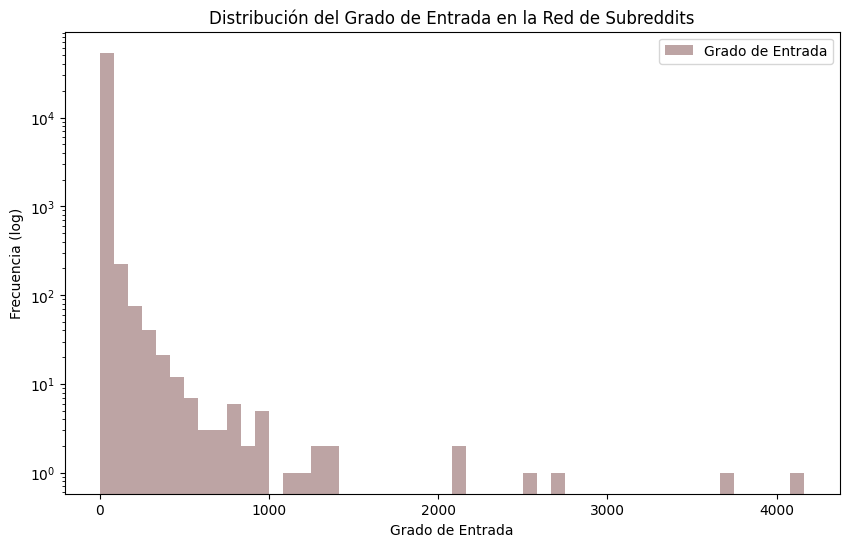

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Red de Subreddits')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

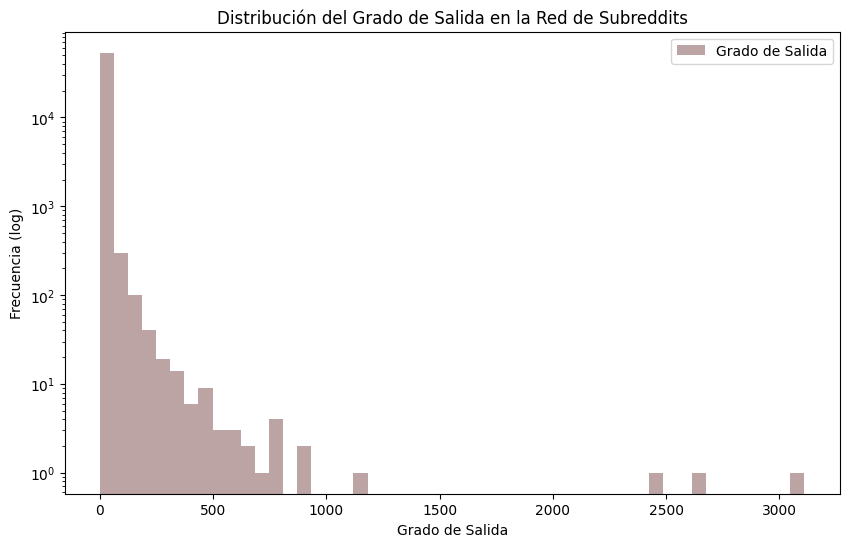

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Red de Subreddits')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

La distribución tiene una forma de cola larga (long-tail), lo cual es típico de muchas redes sociales y naturales. Esto significa que la mayoría de los subreddits tienen un grado de salida relativamente bajo (hacen referencia a unos pocos otros subreddits), mientras que hay unos pocos subreddits con un grado de salida muy alto (hacen referencia a muchos otros subreddits).

Los nodos con un alto grado de salida pueden ser considerados como influenciadores o puntos de difusión clave, ya que enlazan a muchos otros subreddits. Estos subreddits podrían jugar un papel importante en la propagación de información e ideologías.

La naturaleza de la cola larga sugiere que la distribución podría ajustarse a una ley de potencia, lo que es común en las redes de escala libre. Esto implica que hay mecanismos de crecimiento de red como el "attachment preferencial", donde los nuevos enlaces tienen una mayor probabilidad de conectarse a nodos ya bien conectados.

Los subreddits con grados de salida medios a altos podrían ser lugares estratégicos para el monitoreo o la intervención de la difusión de información, especialmente si están relacionados con la política o ideologías específicas.

Las redes con esta distribución de grado son generalmente robustas a la eliminación aleatoria de nodos pero pueden ser vulnerables a ataques dirigidos (es decir, la eliminación de los nodos más conectados).



In [ ]:
density = nx.density(G)
print(f'Densidad de la red: {density}')

Densidad de la red: 8.029680598483293e-05


In [ ]:
# Convertir a grafo no dirigido
G_undirected = G.to_undirected()

# Encontrar todas las componentes conexas
connected_components = list(nx.connected_components(G_undirected))

# Contar el número de componentes conexas
num_connected_components = len(connected_components)
print(f'Número de componentes conexas: {num_connected_components}')

Número de componentes conexas: 758


hay 758 grupos aislados de subreddits en los que cada grupo está interconectado internamente, pero no hay enlaces entre los grupos.

In [ ]:
# Encontrar la componente gigante
largest_component = max(connected_components, key=len)

# Crear un subgrafo que contiene solo los nodos de la componente gigante
subgraph_giant_component = G_undirected.subgraph(largest_component)

# Analizar la componente gigante
num_nodes_giant = subgraph_giant_component.number_of_nodes()
num_edges_giant = subgraph_giant_component.number_of_edges()
density_giant = nx.density(subgraph_giant_component)

print(f'Número de nodos en la componente gigante: {num_nodes_giant}')
#print(f'Número de enlaces en la componente gigante: {num_edges_giant}')
print(f'Densidad de la componente gigante: {density_giant}')

Número de nodos en la componente gigante: 52468
Densidad de la componente gigante: 0.00015932354588831906


La gran mayoría de los subreddits (52,468 de 54,075) están en la componente gigante. Esto implica que casi todos los subreddits están de alguna manera interconectados, aunque sea indirectamente, y podrían influenciarse entre sí a través de una cadena de enlaces.




Esto nos dice que la difusión de información probablemente depende de rutas específicas a través de ciertos nodos clave o influyentes, en lugar de una difusión uniforme a través de la red. Y esto es lo que queremos explorar en nuestro proyecto.

------------------------------

In [ ]:

# Obtener las componentes fuertemente conectadas (SCC) de G
strongly_connected_components = list(nx.strongly_connected_components(G))

# Encontrar la componente gigante (la de mayor tamaño)
giant_component = max(strongly_connected_components, key=len)

# Crear un subgrafo a partir de la componente gigante
G1 = G.subgraph(giant_component).copy()

# Verifica si el subgrafo G1 es dirigido
print(nx.is_directed(G1))  # Esto debería devolver True

True


In [ ]:
len(giant_component)

14389

In [ ]:
num_components = nx.number_weakly_connected_components(G)
print(f"Número de componentes débilmente conectadas: {num_components}")


Número de componentes débilmente conectadas: 758


In [ ]:
weakly_connected_components = list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weakly_connected_components]
component_sizes.sort(reverse=True)  # Ordenar de mayor a menor

print(f"Las 5 componentes más grandes tienen estos tamaños: {component_sizes[:5]}")


Las 5 componentes más grandes tienen estos tamaños: [52468, 8, 7, 6, 6]


In [ ]:
# Encontrar la componente gigante débilmente conectada (Weakly Connected Component)
largest_weakly_connected_component = max(nx.weakly_connected_components(G), key=len)

# Verificar el número de nodos en esta componente antes de crear el subgrafo
print(f"Número de nodos en largest_weakly_connected_component: {len(largest_weakly_connected_component)}")


Número de nodos en largest_weakly_connected_component: 52468


In [ ]:
# Crear un subgrafo a partir de la componente gigante débilmente conectada
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verificar que el subgrafo G1 tiene los mismos nodos
print(f"Número de nodos en G1: {G1.number_of_nodes()}")


Número de nodos en G1: 52468


In [ ]:
# Crear una copia de G1 con los atributos de tipo lista convertidos a cadenas
G1_copy = G1.copy()

for u, v, data in G1_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo G1_copy en un archivo GraphML
nx.write_graphml(G1_copy,  "/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_giant.gexf")



In [ ]:
# Asegúrate de que G1 es una copia real
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verifica si el subgrafo G1 es dirigido
print(f"G1 es dirigido: {nx.is_directed(G1)}")


G1 es dirigido: True


Medidas de centralidad

In [ ]:
# Centralidad de grado
degree_centrality_in = nx.in_degree_centrality(subgraph_political)

# Centralidad de grado
degree_centrality_out = nx.out_degree_centrality(subgraph_political)

# Centralidad de vector propio (eigenvector)
eigenvector_centrality = nx.eigenvector_centrality_numpy(subgraph_political)

# Centralidad de cercanía
closeness_centrality = nx.closeness_centrality(subgraph_political)

# Centralidad de betweenness (aproximada)
k = 200
betweenness_centrality = nx.betweenness_centrality(subgraph_political, k=k, normalized=True, endpoints=False)


In [ ]:
# Convertir los diccionarios en un DataFrame de pandas para facilitar el análisis
centrality_subgraph_df = pd.DataFrame({
    'sdegree_in': pd.Series(degree_centrality_in),
    'sdegree_out': pd.Series(degree_centrality_out),
    'seigenvector': pd.Series(eigenvector_centrality),
    'scloseness': pd.Series(closeness_centrality),
    'sbetweenness': pd.Series(betweenness_centrality)
})

In [ ]:

descriptive_stats = centrality_subgraph_df.describe()
print(descriptive_stats)

        sdegree_in  sdegree_out  seigenvector   scloseness  sbetweenness
count  1727.000000  1727.000000  1.727000e+03  1727.000000   1727.000000
mean      0.000557     0.000557  5.584538e-03     0.012775      0.000093
std       0.002720     0.002216  2.341301e-02     0.027036      0.000834
min       0.000000     0.000000 -2.834279e-17     0.000000      0.000000
25%       0.000000     0.000000 -1.660407e-18     0.000000      0.000000
50%       0.000000     0.000000  7.869889e-19     0.000000      0.000000
75%       0.000000     0.000579  3.230145e-18     0.000000      0.000000
max       0.061993     0.034762  3.114910e-01     0.114046      0.019652


In [ ]:
correlation_matrix = centrality_subgraph_df.corr()
print(correlation_matrix)

              sdegree_in  sdegree_out  seigenvector  scloseness  sbetweenness
sdegree_in      1.000000     0.688017      0.913567    0.485673      0.893648
sdegree_out     0.688017     1.000000      0.692575    0.398428      0.725396
seigenvector    0.913567     0.692575      1.000000    0.617416      0.756341
scloseness      0.485673     0.398428      0.617416    1.000000      0.323334
sbetweenness    0.893648     0.725396      0.756341    0.323334      1.000000


In [ ]:
# Calcular las medias de las centralidades
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)

# Imprimir las medias de las centralidades
print(f"Centralidad de Grado Promedio: {avg_degree_centrality}")
print(f"Centralidad de Vector Propio Promedio: {avg_eigenvector_centrality}")
print(f"Centralidad de Cercanía Promedio: {avg_closeness_centrality}")
print(f"Centralidad de Betweenness Promedio: {avg_betweenness_centrality}")

Centralidad de Grado Promedio: 0.0014206033773097938
Centralidad de Vector Propio Promedio: 0.005584537616749888
Centralidad de Cercanía Promedio: 0.012774775718248116
Centralidad de Betweenness Promedio: 9.277041664567484e-05


In [ ]:
# Función para imprimir los top N nodos más influyentes según una medida de centralidad
def print_top_n_nodes(centrality_dict, n=20, centrality_name="Centralidad"):
    sorted_nodes = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    print(f"Top {n} nodos por {centrality_name}:")
    for i, (node, centrality_value) in enumerate(sorted_nodes, 1):
        print(f"{i}. Nodo: {node}, {centrality_name}: {centrality_value}")
    print("\n")  # Añadir una línea en blanco para separar las listas

# Imprimir los 20 nodos más influyentes según la centralidad de grado
print_top_n_nodes(degree_centrality, 40, "Centralidad de Grado")

# Imprimir los 20 nodos más influyentes según la centralidad de vector propio
print_top_n_nodes(eigenvector_centrality, 40, "Centralidad de Vector Propio")

# Imprimir los 20 nodos más influyentes según la centralidad de cercanía
print_top_n_nodes(closeness_centrality, 40, "Centralidad de Cercanía")

# Imprimir los 20 nodos más influyentes según la centralidad de betweenness
print_top_n_nodes(betweenness_centrality, 40, "Centralidad de Betweenness")

Top 40 nodos por Centralidad de Grado:
1. Nodo: bestof, Centralidad de Grado: 0.20280789546844594
2. Nodo: subredditdrama, Centralidad de Grado: 0.18994995829858216
3. Nodo: iama, Centralidad de Grado: 0.18202668890742285
4. Nodo: titlegore, Centralidad de Grado: 0.144356408117876
5. Nodo: funny, Centralidad de Grado: 0.13775368362524326
6. Nodo: pics, Centralidad de Grado: 0.13170697803725326
7. Nodo: todayilearned, Centralidad de Grado: 0.12100361412288019
8. Nodo: videos, Centralidad de Grado: 0.11516541562413123
9. Nodo: gaming, Centralidad de Grado: 0.10467055879899917
10. Nodo: the_donald, Centralidad de Grado: 0.08305532388101196
11. Nodo: drama, Centralidad de Grado: 0.08152627189324438
12. Nodo: news, Centralidad de Grado: 0.07360300250208507
13. Nodo: conspiracy, Centralidad de Grado: 0.07290797887128163
14. Nodo: worldnews, Centralidad de Grado: 0.0725604670558799
15. Nodo: wtf, Centralidad de Grado: 0.06978037253266611
16. Nodo: science, Centralidad de Grado: 0.064081178760

In [ ]:
# Función para convertir todos los atributos a string
def convert_attributes_to_string(G):
    for node, attrs in G.nodes(data=True):
        for attr, value in attrs.items():
            # Convertir el valor del atributo a string
            G.nodes[node][attr] = str(value)
    for source, target, attrs in G.edges(data=True):
        for attr, value in attrs.items():
            # Convertir el valor del atributo a string
            G[source][target][attr] = str(value)

# Copia del subgrafo para no modificar el original
subgraph_political_copy = subgraph_political.copy()

# Convertir todos los atributos del subgrafo a string
convert_attributes_to_string(subgraph_political_copy)

# Ruta de acceso para guardar el archivo
output_file_path = '/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_political.gexf'

# Guardar el grafo en formato GEXF
nx.write_gexf(subgraph_political_copy, output_file_path)

Componente gigante del subgrafo

In [ ]:
# Encontrar las componentes conectadas (si el grafo es no dirigido) o fuertemente conectadas (si es dirigido)
connected_components = list(nx.strongly_connected_components(subgraph_political))

# Encontrar la componente gigante (la de mayor tamaño)
giant_component = max(connected_components, key=len)

# Crear un subgrafo a partir de la componente gigante
subgraph_political_giant = subgraph_political.subgraph(giant_component).copy()

# Imprimir el número de nodos en la componente gigante
print(f"El número de nodos en la componente gigante es: {subgraph_political_giant.number_of_nodes()}")


El número de nodos en la componente gigante es: 196


In [ ]:
# Crear una copia de subgraph_political_giant con los atributos de tipo lista convertidos a cadenas
subgraph_political_giant_copy = subgraph_political_giant.copy()

for u, v, data in subgraph_political_giant_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo subgraph_political_giant_copy en un archivo GraphML
nx.write_graphml(subgraph_political_giant_copy, '/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_political_giant.graphml')


##Top nodos con sentimiento negativo

In [ ]:
# Asignar el atributo 'post_label' al nodo de salida de cada arista
for u, v, data in subgraph_political.edges(data=True):
    # Verificamos si la arista tiene el atributo 'post_label'
    post_label = data.get('post_label')

    if post_label is not None:
        # Asignamos el valor de 'post_label' al nodo de salida (source)
        subgraph_political.nodes[u]['post_label'] = post_label
        print(f"Nodo {u} asignado con post_label: {post_label}")


Nodo occupyseattle asignado con post_label: 1
Nodo aaronswartz asignado con post_label: 1
Nodo britishcommunists asignado con post_label: 1
Nodo libertarianfiction asignado con post_label: 1
Nodo rightwinglgbt asignado con post_label: -1
Nodo rightwinglgbt asignado con post_label: -1
Nodo rightwinglgbt asignado con post_label: -1
Nodo religiousanarchism asignado con post_label: 1
Nodo canadian_socialism asignado con post_label: 1
Nodo musichistory asignado con post_label: 1
Nodo tristateleftism asignado con post_label: 1
Nodo endlesswar asignado con post_label: 1
Nodo endlesswar asignado con post_label: 1
Nodo endlesswar asignado con post_label: 1
Nodo endlesswar asignado con post_label: 1
Nodo endlesswar asignado con post_label: 1
Nodo endlesswar asignado con post_label: -1
Nodo peoplesmetanarchism asignado con post_label: 1
Nodo warthunder asignado con post_label: 1
Nodo warthunder asignado con post_label: 1
Nodo warthunder asignado con post_label: 1
Nodo warthunder asignado con post

In [ ]:
import networkx as nx

# Calcular la centralidad de grado para todos los nodos en el subgrafo político
degree_centrality = nx.degree_centrality(subgraph_political)

# Filtrar los nodos que tienen un 'post_label' de -1
nodes_with_negative_post_label = [node for node, data in subgraph_political.nodes(data=True) if data.get('post_label') == -1]

# Filtrar los nodos que tienen un 'post_label' de -1 y calcular su centralidad de grado
degree_centrality_filtered = {node: degree_centrality[node] for node in nodes_with_negative_post_label}

# Ordenar los nodos por centralidad de grado de mayor a menor
sorted_nodes = sorted(degree_centrality_filtered.items(), key=lambda x: x[1], reverse=True)

# Obtener los 45 nodos más centrales
top_45_nodes = sorted_nodes[:45]

# Mostrar los nodos seleccionados
print("Top 45 nodos con mayor centralidad de grado y 'post_label = -1':")
for node, centrality in top_45_nodes:
    print(f"Node: {node}, Degree Centrality: {centrality}")


Top 45 nodos con mayor centralidad de grado y 'post_label = -1':
Node: anarchism, Degree Centrality: 0.04808806488991889
Node: panichistory, Degree Centrality: 0.013904982618771726
Node: shitsocialismsays, Degree Centrality: 0.009269988412514484
Node: capitalismvsocialism, Degree Centrality: 0.009269988412514484
Node: libertarianbestof, Degree Centrality: 0.006373117033603708
Node: endlesswar, Degree Centrality: 0.005214368482039398
Node: nationalsocialism, Degree Centrality: 0.004055619930475087
Node: qualitysocialism, Degree Centrality: 0.0034762456546929316
Node: australianpolitics, Degree Centrality: 0.0034762456546929316
Node: antifa, Degree Centrality: 0.0034762456546929316
Node: isrconservativeracist, Degree Centrality: 0.0028968713789107765
Node: rightwinglgbt, Degree Centrality: 0.002317497103128621
Node: liberalism, Degree Centrality: 0.0017381228273464658
Node: socialistsvsfeminism, Degree Centrality: 0.0017381228273464658
Node: bestofconservative, Degree Centrality: 0.00115

In [ ]:
import networkx as nx
import random

# Asignamos un umbral por defecto para todos los nodos si no lo tienen definido
default_threshold = 0.5
for node in G1.nodes():
    if node not in thresholds:
        thresholds[node] = default_threshold

# Función corregida para manejar divisiones por cero
def threshold_diffusion(G, initial_nodes, thresholds):
    adopted = set(initial_nodes)  # Nodos que ya adoptaron la ideología
    newly_adopted = set(initial_nodes)

    while newly_adopted:
        next_adopted = set()

        # Recorremos todos los nodos que aún no han adoptado
        for node in set(G.nodes()) - adopted:
            predecessors = list(G.predecessors(node))  # Vecinos que apuntan a este nodo
            if len(predecessors) == 0:
                continue  # Si no tiene vecinos que lo influencien, omitimos este nodo

            # Contar cuántos de sus vecinos ya adoptaron la ideología
            active_neighbors = sum(1 for neighbor in predecessors if neighbor in adopted)

            # Si la proporción de vecinos adoptados supera el umbral, el nodo también adopta la ideología
            if active_neighbors / len(predecessors) > thresholds[node]:
                next_adopted.add(node)

        newly_adopted = next_adopted
        adopted.update(newly_adopted)

    return adopted

# Nodos iniciales que empiezan con la ideología (por ejemplo, los 45 nodos encontrados antes)
initial_nodes = top_45_nodes

# Correr el modelo de difusión basado en threshold en G1 (la componente gigante)
adopted_nodes = threshold_diffusion(G1, initial_nodes, thresholds)

print(f"Nodos que adoptaron la ideología: {len(adopted_nodes)}")


Nodos que adoptaron la ideología: 35


In [ ]:
len(G1)

52468